# Important

**Check GPU**

In [1]:
!nvidia-smi

Thu Jan 27 15:43:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Translate

Какой функционал можно добавить: проверить качество с пунктуацией и без, убрать вводные слова

In [2]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 596 kB 50.6 MB/s 
     |████████████████████████████████| 67 kB 3.6 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-ru-en"
translator = pipeline("translation", model=model_checkpoint)
translator("Хочу пиццу")

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/293M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

[{'translation_text': 'I want pizza.'}]

In [4]:
%%time

translator("Подожди ты забыл пирожок")

CPU times: user 648 ms, sys: 5.3 ms, total: 653 ms
Wall time: 660 ms


[{'translation_text': 'Wait, you forgot the cake.'}]

# Dataset

**Kaggle Dataset**

In [5]:
!pip install opendatasets

In [6]:
import opendatasets as od

Для следующей ячейки потребуются данные из Kaggle аккаунта:

You Profile -> Account -> Create New API Token

In [ ]:
od.download("https://www.kaggle.com/jessicali9530/stl10")

# CLIP

За основу взят репозиторий: https://github.com/haltakov/natural-language-image-search

In [8]:
!pip install git+https://github.com/openai/CLIP.git
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7__1cip_
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-7__1cip_
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369221 sha256=31351d67bed88d8a35e40212de98833573e7737d581e96730cd205c9178d58c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-72l7hr6s/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=d7feaa7bdc189c2b91adcadaf3896c6ea0f5c325c18f6e766b4b76e4d41952ad
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


In [9]:
!mkdir features

In [10]:
from pathlib import Path

batch_size = 512

images_dir = "/content/stl10/train_images"
features_dir = "/content/features"

photos_path = Path(images_dir) 
features_path = Path(features_dir)

# List all picture in the folder
photos_files = list(photos_path.glob("*.png"))

# Print some statistics
print(f"Photos found: {len(photos_files)}")

Photos found: 5000


In [11]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [12]:
import clip
import torch
from PIL import Image, ImageFile
import math
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
from IPython.display import Image as Img
from IPython.display import display

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 168MiB/s]


In [13]:
# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

In [14]:
# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)
print(f"All batches: {batches}")

# Process each batch
for i in tqdm(range(batches)):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : min(len(photos_files), (i+1)*batch_size)]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

All batches: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10


In [15]:
def add_photo_path(name):
  return f'{images_dir}/{name}.png'

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids = photo_ids["photo_id"].apply(add_photo_path)
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)

In [16]:
def encode_search_query(search_query):
  with torch.no_grad():
    # Encode it to a feature vector using CLIP
    text_encoded = model.encode_text(clip.tokenize(search_query).to(device))
    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

  # Retrieve the description vector and the photo vectors
  return text_encoded.cpu().numpy()

def find_best(text_features, photo_features, photo_ids, counter=5):
  # Compute the similarity between the search query and each photo using the Cosine similarity
  similarities = (photo_features @ text_features.T).squeeze(1)

  # Sort the photos by their similarity score -> best_photo_idx = Sorted list of photo indexes
  best_photo_idx = np.argsort(similarities)[::-1]

  # Return the photo IDs of the best matches, cosine similarity and sorted list of photo indexes
  return [photo_ids[i] for i in best_photo_idx[:counter]], similarities, best_photo_idx


def text_search(search_query, photo_features, photo_ids, counter=5):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  best_photo_name, similarities, best_photo_idx = find_best(text_features, photo_features, photo_ids, counter)

  for i in range(counter):
    print("Photo name: {} | Cosine similarity: {}".format(best_photo_name[i],similarities[best_photo_idx[i]]))
  
  # Display photos
  for photo in best_photo_name:
    display(Img(photo))

In [17]:
# load the img idx
photo_ids = list(pd.read_csv(f"{features_dir}/photo_ids.csv")['photo_id'])

# load the features vectors
photo_features = np.load(f"{features_dir}/features.npy")

Small monkey
Photo name: /content/stl10/train_images/train_image_png_1814.png | Cosine similarity: 0.311767578125
Photo name: /content/stl10/train_images/train_image_png_3279.png | Cosine similarity: 0.30712890625
Photo name: /content/stl10/train_images/train_image_png_4511.png | Cosine similarity: 0.30615234375


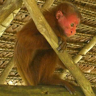

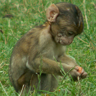

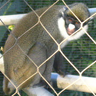

In [18]:
#text = translator("Черная кошка сидит")[0]['translation_text']
text = "Small monkey"
print(text)
text_search(text, photo_features, photo_ids, 3)